## parquet paths

In [1]:
!ls ../dataset/piraeus/

107782 - The Piraeus AIS Dataset for Large-Scale Maritime Data Analytics.pdf
ais_augmented.parquet
ais_cleaned.parquet
ais_loiter.parquet
ais_loiter_pair.parquet
ais_static
geodata
models
noaa_weather
parquet
processed
sar
unipi_ais_dynamic_2017
unipi_ais_dynamic_2018
unipi_ais_dynamic_2019
unipi_ais_dynamic_synopses


In [25]:
!ls "../dataset/piraeus/parquet/unipi_ais_dynamic_2017"

unipi_ais_dynamic_aug2017.parquet
unipi_ais_dynamic_dec2017.parquet
unipi_ais_dynamic_jul2017.parquet
unipi_ais_dynamic_jun2017.parquet
unipi_ais_dynamic_may2017.parquet
unipi_ais_dynamic_nov2017.parquet
unipi_ais_dynamic_oct2017.parquet
unipi_ais_dynamic_sep2017.parquet


In [2]:
!ls ../dataset/piraeus/unipi_ais_dynamic_2017

README.md
unipi_ais_dynamic_aug2017.csv
unipi_ais_dynamic_dec2017.csv
unipi_ais_dynamic_jul2017.csv
unipi_ais_dynamic_jun2017.csv
unipi_ais_dynamic_may2017.csv
unipi_ais_dynamic_nov2017.csv
unipi_ais_dynamic_oct2017.csv
unipi_ais_dynamic_sep2017.csv


In [3]:
!ls ../dataset/piraeus/unipi_ais_dynamic_2018

README.md
unipi_ais_dynamic_apr2018.csv
unipi_ais_dynamic_aug2018.csv
unipi_ais_dynamic_dec2018.csv
unipi_ais_dynamic_feb2018.csv
unipi_ais_dynamic_jan2018.csv
unipi_ais_dynamic_jul2018.csv
unipi_ais_dynamic_jun2018.csv
unipi_ais_dynamic_mar2018.csv
unipi_ais_dynamic_may2018.csv
unipi_ais_dynamic_nov2018.csv
unipi_ais_dynamic_oct2018.csv
unipi_ais_dynamic_sep2018.csv


In [4]:
!ls ../dataset/piraeus/unipi_ais_dynamic_2019

README.md
unipi_ais_dynamic_apr2019.csv
unipi_ais_dynamic_aug2019.csv
unipi_ais_dynamic_dec2019.csv
unipi_ais_dynamic_feb2019.csv
unipi_ais_dynamic_jan2019.csv
unipi_ais_dynamic_jul2019.csv
unipi_ais_dynamic_jun2019.csv
unipi_ais_dynamic_mar2019.csv
unipi_ais_dynamic_may2019.csv
unipi_ais_dynamic_nov2019.csv
unipi_ais_dynamic_oct2019.csv
unipi_ais_dynamic_sep2019.csv


In [5]:
import pandas, pyarrow
print(pandas.__version__)
print(pyarrow.__version__)

2.3.3
23.0.0


In [6]:
from tqdm import tqdm

In [7]:
import pyarrow.parquet as pq

pq_file = pq.ParquetFile("unipi_ais_dynamic_may2017.parquet")

# Suppose row groups are ~500k rows each
row_group_index = 6  # 6*500k = 3Mth row
table = pq_file.read_row_group(row_group_index)

df_chunk = table.to_pandas()  # Only this row group in memory
row = df_chunk.iloc[0]  # Approx 3Mth row
print(row)


t                                                1494345047000
vessel_id    b0b2bd45bbb8911fbea20744b0e8b98bbb0e76f6c3af37...
lat                                                  37.929298
lon                                                  23.682772
heading                                                   30.0
speed                                                      0.0
course                                                   170.0
Name: 0, dtype: object


## Random Access

In [8]:
import platform; print(platform.architecture()); import sys; print(sys.version)

('64bit', 'WindowsPE')
3.10.19 | packaged by conda-forge | (main, Jan 26 2026, 23:39:36) [MSC v.1944 64 bit (AMD64)]


## Bounds

In [9]:
import pandas as pd

# Adjust to your file path
file = "../dataset/piraeus/unipi_ais_dynamic_2017/unipi_ais_dynamic_may2017.csv"

# Chunked read in case of large files
chunksize = 1_000_000
min_lat, max_lat = float('inf'), float('-inf')
min_lon, max_lon = float('inf'), float('-inf')

for chunk in pd.read_csv(file, usecols=['lat', 'lon'], chunksize=chunksize):
    min_lat = min(min_lat, chunk['lat'].min())
    max_lat = max(max_lat, chunk['lat'].max())
    min_lon = min(min_lon, chunk['lon'].min())
    max_lon = max(max_lon, chunk['lon'].max())

print("Bounds:")
print("Latitude:", min_lat, "-", max_lat)
print("Longitude:", min_lon, "-", max_lon)


Bounds:
Latitude: 37.45947 - 38.03808166666671
Longitude: 23.0350833333333 - 23.8806466666667


# Unique

In [11]:
import pyarrow.parquet as pq


def unique_vessels_parquet(path: str) -> set[str]:
    """
    Return unique vessel_id values from a parquet file
    without loading the full file into memory.
    """
    pq_file = pq.ParquetFile(path)
    vessels: set[str] = set()

    for i in range(pq_file.num_row_groups):
        table = pq_file.read_row_group(i, columns=["vessel_id"])
        vessels.update(table.column("vessel_id").to_pylist())

    return vessels


vessels = unique_vessels_parquet("unipi_ais_dynamic_may2017.parquet")
print(len(vessels))


778


In [24]:
from pathlib import Path
import pyarrow.parquet as pq


def count_unique_vessels(path: Path) -> int:
    """
    Count unique vessel_id values in a parquet file
    using row-group iteration to stay memory safe.
    """
    pq_file = pq.ParquetFile(path)
    vessels = set()

    for i in range(pq_file.num_row_groups):
        table = pq_file.read_row_group(i, columns=["vessel_id"])
        vessels.update(table.column("vessel_id").to_pylist())

    return len(vessels)


def scan_parquet_directory(base_dir: Path) -> dict[str, int]:
    """
    Scan all parquet files under base_dir
    and return {filename: unique_vessel_count}.
    """
    results: dict[str, int] = {}

    for p in sorted(base_dir.rglob("*.parquet")):
        results[p.name] = count_unique_vessels(p)

    return results

results = scan_parquet_directory(Path("../dataset/piraeus/parquet/unipi_ais_dynamic_2017"))
print(results)

{'unipi_ais_dynamic_aug2017.parquet': 1069, 'unipi_ais_dynamic_dec2017.parquet': 821, 'unipi_ais_dynamic_jul2017.parquet': 1135, 'unipi_ais_dynamic_jun2017.parquet': 1119, 'unipi_ais_dynamic_may2017.parquet': 778, 'unipi_ais_dynamic_nov2017.parquet': 871, 'unipi_ais_dynamic_oct2017.parquet': 816, 'unipi_ais_dynamic_sep2017.parquet': 1135}


In [26]:
import matplotlib.pyplot as plt


def plot_unique_vessels(stats: dict[str, int]) -> None:
    """
    Plot unique vessel count per parquet file.
    """
    names = list(stats.keys())
    counts = list(stats.values())

    plt.figure()
    plt.plot(names, counts, marker="o")
    plt.xlabel("Parquet file")
    plt.ylabel("Unique vessels")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


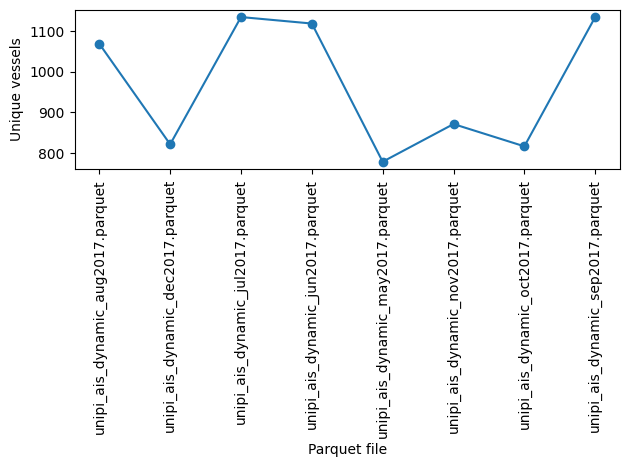

In [28]:
base_dir = Path("../dataset/piraeus/parquet/unipi_ais_dynamic_2017")

stats = scan_parquet_directory(base_dir)
plot_unique_vessels(stats)


In [49]:
base_dir = Path("../dataset/piraeus/parquet")

stats = scan_parquet_directory(base_dir)

In [50]:
stats

{'unipi_ais_dynamic_aug2017.parquet': 1069,
 'unipi_ais_dynamic_dec2017.parquet': 821,
 'unipi_ais_dynamic_jul2017.parquet': 1135,
 'unipi_ais_dynamic_jun2017.parquet': 1119,
 'unipi_ais_dynamic_may2017.parquet': 778,
 'unipi_ais_dynamic_nov2017.parquet': 871,
 'unipi_ais_dynamic_oct2017.parquet': 816,
 'unipi_ais_dynamic_sep2017.parquet': 1135,
 'unipi_ais_dynamic_apr2018.parquet': 884,
 'unipi_ais_dynamic_aug2018.parquet': 1162,
 'unipi_ais_dynamic_dec2018.parquet': 848,
 'unipi_ais_dynamic_feb2018.parquet': 669,
 'unipi_ais_dynamic_jan2018.parquet': 659,
 'unipi_ais_dynamic_jul2018.parquet': 1344,
 'unipi_ais_dynamic_jun2018.parquet': 1242,
 'unipi_ais_dynamic_mar2018.parquet': 795,
 'unipi_ais_dynamic_may2018.parquet': 1035,
 'unipi_ais_dynamic_nov2018.parquet': 849,
 'unipi_ais_dynamic_oct2018.parquet': 1074,
 'unipi_ais_dynamic_sep2018.parquet': 1136,
 'unipi_ais_dynamic_apr2019.parquet': 1055,
 'unipi_ais_dynamic_aug2019.parquet': 1408,
 'unipi_ais_dynamic_dec2019.parquet': 1048

In [51]:
sorted(stats.items(), key=lambda x: x[1])  # Sort by unique vessel count stats

[('unipi_ais_dynamic_jun2019.parquet', 443),
 ('unipi_ais_dynamic_jan2018.parquet', 659),
 ('unipi_ais_dynamic_feb2018.parquet', 669),
 ('unipi_ais_dynamic_may2017.parquet', 778),
 ('unipi_ais_dynamic_jan2019.parquet', 782),
 ('unipi_ais_dynamic_mar2018.parquet', 795),
 ('unipi_ais_dynamic_oct2017.parquet', 816),
 ('unipi_ais_dynamic_dec2017.parquet', 821),
 ('unipi_ais_dynamic_dec2018.parquet', 848),
 ('unipi_ais_dynamic_nov2018.parquet', 849),
 ('unipi_ais_dynamic_nov2017.parquet', 871),
 ('unipi_ais_dynamic_feb2019.parquet', 874),
 ('unipi_ais_dynamic_apr2018.parquet', 884),
 ('unipi_ais_dynamic_may2018.parquet', 1035),
 ('unipi_ais_dynamic_mar2019.parquet', 1045),
 ('unipi_ais_dynamic_dec2019.parquet', 1048),
 ('unipi_ais_dynamic_apr2019.parquet', 1055),
 ('unipi_ais_dynamic_aug2017.parquet', 1069),
 ('unipi_ais_dynamic_oct2018.parquet', 1074),
 ('unipi_ais_dynamic_nov2019.parquet', 1092),
 ('unipi_ais_dynamic_jun2017.parquet', 1119),
 ('unipi_ais_dynamic_jul2017.parquet', 1135),
 

In [52]:
sorted(stats)  

['unipi_ais_dynamic_apr2018.parquet',
 'unipi_ais_dynamic_apr2019.parquet',
 'unipi_ais_dynamic_aug2017.parquet',
 'unipi_ais_dynamic_aug2018.parquet',
 'unipi_ais_dynamic_aug2019.parquet',
 'unipi_ais_dynamic_dec2017.parquet',
 'unipi_ais_dynamic_dec2018.parquet',
 'unipi_ais_dynamic_dec2019.parquet',
 'unipi_ais_dynamic_feb2018.parquet',
 'unipi_ais_dynamic_feb2019.parquet',
 'unipi_ais_dynamic_jan2018.parquet',
 'unipi_ais_dynamic_jan2019.parquet',
 'unipi_ais_dynamic_jul2017.parquet',
 'unipi_ais_dynamic_jul2018.parquet',
 'unipi_ais_dynamic_jul2019.parquet',
 'unipi_ais_dynamic_jun2017.parquet',
 'unipi_ais_dynamic_jun2018.parquet',
 'unipi_ais_dynamic_jun2019.parquet',
 'unipi_ais_dynamic_mar2018.parquet',
 'unipi_ais_dynamic_mar2019.parquet',
 'unipi_ais_dynamic_may2017.parquet',
 'unipi_ais_dynamic_may2018.parquet',
 'unipi_ais_dynamic_may2019.parquet',
 'unipi_ais_dynamic_nov2017.parquet',
 'unipi_ais_dynamic_nov2018.parquet',
 'unipi_ais_dynamic_nov2019.parquet',
 'unipi_ais_

In [53]:
import re


_MONTH_MAP = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4,
    "may": 5, "jun": 6, "jul": 7, "aug": 8,
    "sep": 9, "oct": 10, "nov": 11, "dec": 12,
}


def sort_stats_chronologically(stats: dict[str, int]) -> dict[str, int]:
    """
    Sort stats dict by year, then month extracted from filename.
    """
    def key_fn(name: str) -> tuple[int, int]:
        m = re.search(r"_(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)(\d{4})", name)
        month = _MONTH_MAP[m.group(1)]
        year = int(m.group(2))
        return year, month

    return dict(sorted(stats.items(), key=lambda x: key_fn(x[0])))


In [59]:
def clean_labels(stats: dict[str, int]) -> dict[str, int]:
    """
    Remove dataset prefix and file extension from filenames.
    """
    cleaned: dict[str, int] = {}

    for k, v in stats.items():
        label = k.replace("unipi_ais_dynamic_", "")
        label = label.replace(".parquet", "")
        cleaned[label] = v

    return cleaned


In [60]:
stats_ = sort_stats_chronologically(stats)
stats_ = clean_labels(stats_)

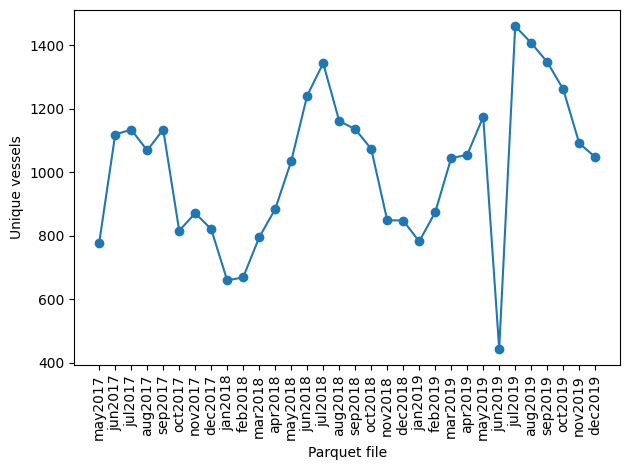

In [61]:
plot_unique_vessels(stats_)

## plotly version

In [ ]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "browser"


def plot_unique_vessels_plotly(stats: dict[str, int]) -> None:
    """
    Plot unique vessel count per parquet file using Plotly.
    """
    fig = px.line(
        x=list(stats.keys()),
        y=list(stats.values()),
        labels={
            "x": "Parquet file",
            "y": "Unique vessels",
        },
        markers=True,
        title="Unique vessels per parquet file",
    )

    fig.update_layout(xaxis_tickangle=90)
    fig.show()

In [63]:
plot_unique_vessels_plotly(stats_)
